O serviço de vendas de carros usados Rusty Bargain está desenvolvendo um aplicativo para atrair novos clientes. Nesse aplicativo, você pode descobrir rapidamente o valor de mercado do seu carro. Você tem acesso a dados históricos: especificações técnicas, versões de acabamento e preços. Você precisa construir o modelo para determinar o valor. 

Rusty Bargain está interessado em:

- a qualidade da predição;
- a velocidade da predição;
- o tempo necessário para o treinamento

## Preparação de Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import category_encoders as ce

In [2]:
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.shape

(354369, 16)

`DateCrawled` — data em que o perfil foi baixado do banco de dados

`VehicleType` — tipo de carroçaria do veículo

`RegistrationYear` — ano de matrícula do veículo

`Gearbox` — tipo de caixa de transmissão

`Power` — potência (hp)

`Model` — modelo do veículo

`Mileage` — quilometragem (medida em km devido às especificidades regionais do
conjunto de dados)

`RegistrationMonth` — vehicle registration month

`FuelType` — tipo de combustível

`Brand` — marca do veículo

`NotRepaired` — veículo reparado ou não

`DateCreated` — data de criação do perfil

`NumberOfPictures` — número de fotos do veículo

`PostalCode` — código postal do proprietário do perfil (usuário)

`LastSeen` — data da última atividade do usuário

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Mileage,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [7]:
df.isnull().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Mileage              0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [8]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')
df[['DateCrawled', 'DateCreated',
    'LastSeen']].describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
DateCrawled,354369,2016-03-21 12:57:41.165057280,2016-03-05 14:06:00,2016-03-13 11:52:00,2016-03-21 17:50:00,2016-03-29 14:37:00,2016-04-07 14:36:00
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00
LastSeen,354369,2016-03-29 23:50:30.593703680,2016-03-05 14:15:00,2016-03-23 02:50:00,2016-04-03 15:15:00,2016-04-06 10:15:00,2016-04-07 14:58:00


In [9]:
df['NotRepaired'].fillna(value='unknown', inplace=True)
df['NotRepaired'].isnull().sum()

0

In [10]:
df['Model'].fillna('other', inplace=True)
df['Model'].isnull().sum()

0

In [11]:
df['RegistrationYear'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 151, dtype: int64

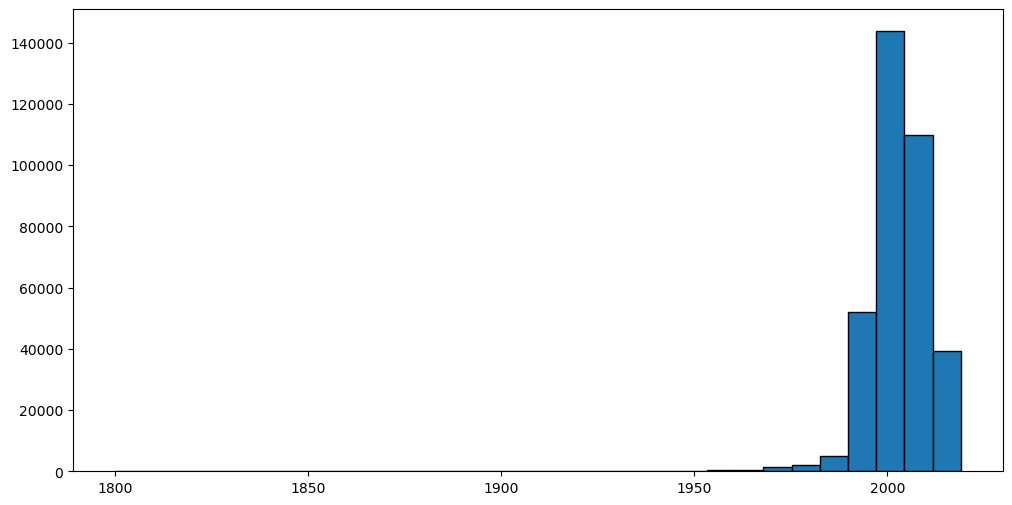

In [12]:
# Filtrar os anos de registro dentro de um intervalo razoável
filtered_df = df[(df['RegistrationYear'] >= 1800)
                 & (df['RegistrationYear'] <= 2023)]

plt.figure(figsize=(12, 6))
plt.hist(filtered_df['RegistrationYear'], bins=30, edgecolor='k')
plt.show()

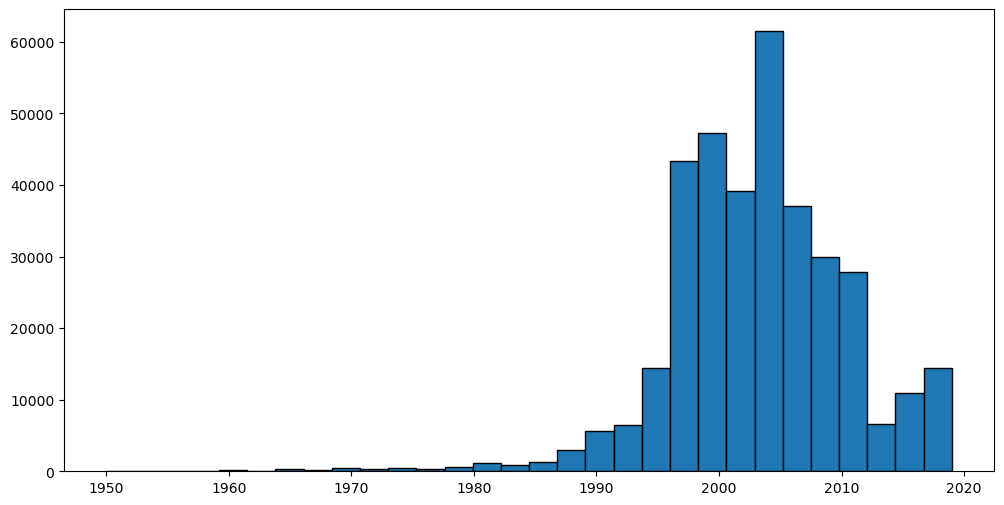

In [13]:
df = df[(1950 <= df['RegistrationYear']) & (df['RegistrationYear'] <= 2020)]
plt.figure(figsize=(12, 6))
plt.hist(df['RegistrationYear'], bins=30, edgecolor='k')
plt.show()

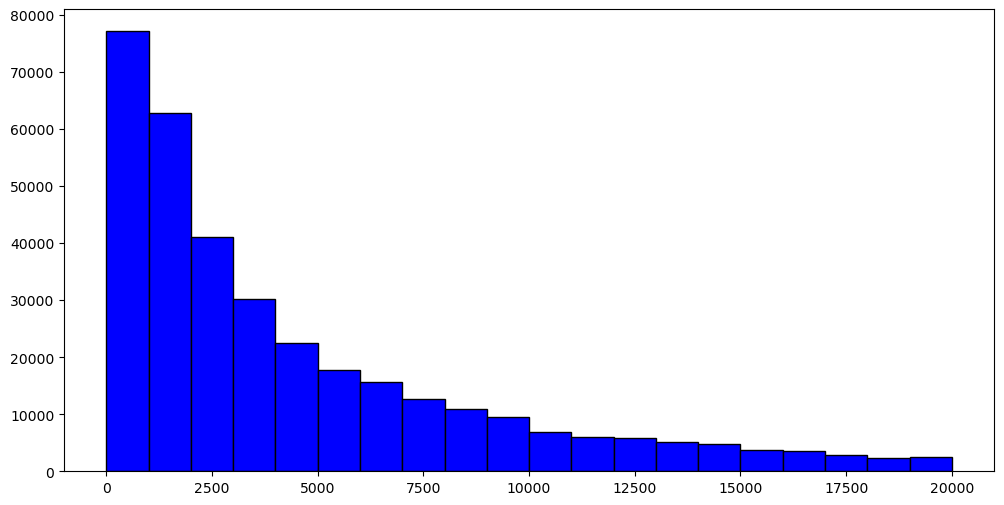

In [14]:
df = df[df['Price'] > 0]

plt.figure(figsize=(12, 6))
plt.hist(df['Price'], bins=20, edgecolor='k', color='blue')

plt.show()

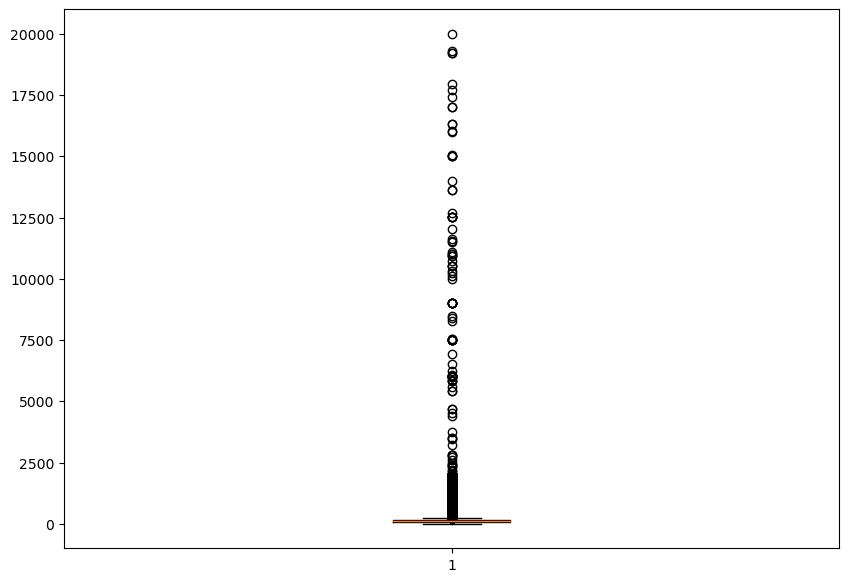

In [15]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(df['Power'])
plt.show()

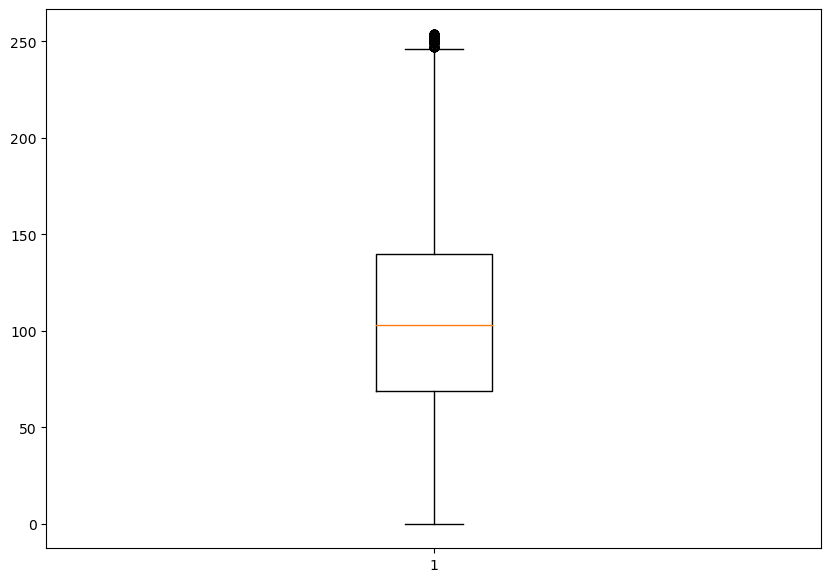

In [16]:
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)

IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df = df[(df['Power'] >= limite_inferior) & (df['Power'] <= limite_superior)]

fig = plt.figure(figsize=(10, 7))
plt.boxplot(df['Power'])
plt.show()

In [17]:
def fill_missing_with_common(df, groupby_col, fill_col):
    common_values = df.groupby(groupby_col)[fill_col].apply(
        lambda x: x.mode().iat[0] if not x.mode().empty else None).to_dict()

    df[fill_col].fillna(df[groupby_col].map(common_values), inplace=True)

In [18]:
fill_missing_with_common(df, 'Model', 'FuelType')
df['FuelType'].isnull().sum()

0

In [19]:
fill_missing_with_common(df, 'Model', 'Gearbox')
df['Gearbox'].isnull().sum()

0

In [20]:
fill_missing_with_common(df, 'Model', 'VehicleType')
df['VehicleType'].isnull().sum()

0

In [21]:
df.drop(['NumberOfPictures'], axis=1, inplace=True)

In [22]:
df.duplicated().sum()

265

In [23]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [24]:
df['UserDays'] = (df['LastSeen'] - df['DateCreated']).dt.days

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335940 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        335940 non-null  datetime64[ns]
 1   Price              335940 non-null  int64         
 2   VehicleType        335940 non-null  object        
 3   RegistrationYear   335940 non-null  int64         
 4   Gearbox            335940 non-null  object        
 5   Power              335940 non-null  int64         
 6   Model              335940 non-null  object        
 7   Mileage            335940 non-null  int64         
 8   RegistrationMonth  335940 non-null  int64         
 9   FuelType           335940 non-null  object        
 10  Brand              335940 non-null  object        
 11  NotRepaired        335940 non-null  object        
 12  DateCreated        335940 non-null  datetime64[ns]
 13  PostalCode         335940 non-null  int64   

1. Importação de Bibliotecas:
- Começamos importando bibliotecas essenciais, como pandas, matplotlib e scikit-learn. Essas bibliotecas são necessárias para manipular os dados, visualizá-los e realizar tarefas de aprendizado de máquina.

2. Leitura do Conjunto de Dados:
- Tentei ler o conjunto de dados a partir de `car_data.csv`, mas, caso não estivesse lá, o código tentaria lê-lo de `/datasets/car_data.csv` que é onde está armazenado na plataforma da TripleTen. 

3. Visualização Inicial do Conjunto de Dados:
- Exibimos as primeiras linhas do conjunto de dados com df.head(). Isso ajuda a entender a estrutura dos dados e garantir que a leitura tenha ocorrido corretamente.

4. Informações Gerais sobre o Conjunto de Dados:
- Usei df.info() para obter informações detalhadas sobre o conjunto de dados, como número de entradas, colunas e tipos de dados. Isso ajuda a verificar rapidamente a qualidade dos dados.

5. Verificação de Valores Nulos:
- Utilizei df.isnull().mean().sort_values(ascending=False) para verificar a porcentagem de valores nulos em cada coluna. Isso é crucial para identificar a necessidade de tratamento de valores ausentes.

6. Conversão de Colunas de Data:
- Converti as colunas de data (`DateCrawled`, `DateCreated` e `LastSeen`) para o formato de data usando pd.to_datetime.

7. Tratamento de Valores Nulos:
- Preenchi valores nulos nas colunas `NotRepaired` e `Model` com `unknown` e `other`, respectivamente. Essas escolhas foram feitas para não perder informações importantes e manter a integridade dos dados.

8. Análise da Coluna `RegistrationYear`:
- Verifiquei a distribuição dos anos de registro. Para evitar valores extremos, mantive apenas os anos entre 1950 e 2020, considerando a realidade dos carros.

9. Análise da Coluna `Price`:
- Analisei a distribuição dos preços dos carros e removi valores iguais ou menores a zero, pois preços não positivos não fazem sentido.

10. Análise da Coluna `Power`:
- Visualizei os dados usando um boxplot para identificar outliers. Removi os valores discrepantes usando o método do Intervalo Interquartil (IQR).

11. Imputação de Valores Ausentes:
- Imputei valores ausentes nas colunas categóricas `FuelType`, `Gearbox` e `VehicleType` com base no valor mais comum no grupo `Model`. Isso ajuda a manter a consistência nos dados categóricos.

12. Remoção da Coluna `NumberOfPictures`:
- Removi a coluna `NumberOfPictures` porque todos os valores eram zero, não contribuindo para análises futuras.

13. Remoção de Duplicatas:
- Identifiquei e removi duplicatas do conjunto de dados para garantir que cada entrada seja única.

14. Criação da Coluna `UserDays`:
- Criei uma nova coluna `UserDays` para representar o número de dias entre `LastSeen` e `DateCreated`.

**Conclusão Geral:**

Realizei uma preparação dos dados, abordando valores nulos, outliers, valores inválidos e imputação inteligente de dados categóricos. A limpeza e transformação dos dados são cruciais para garantir que o conjunto de dados esteja em um estado adequado. 

## Treinamento do modelo

In [26]:
df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1, inplace=True)

In [27]:
features = df.drop(['Price', 'PostalCode'], axis=1)
target = df['Price']

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [29]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=42)

In [57]:
features_train_encoder, features_valid_encoder, features_test_encoder = features_train.copy(
), features_valid.copy(), features_test.copy()
cat_features = [
    'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'
]


def encod(data):
    one_hot_cols = [x for x in cat_features if data[x].nunique() <= 3]
    encoding_cols = list(set(cat_features) - set(one_hot_cols))
    numerical_cols = ['Power', 'Mileage']

    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    encoder = ce.OneHotEncoder(cols=one_hot_cols)
    data = encoder.fit_transform(data)

    encoder = LabelEncoder()
    for col in encoding_cols:
        data[col] = encoder.fit_transform(data[col])

    return data

In [58]:
features_train_encoder = encod(features_train_encoder)
features_valid_encoder = encod(features_valid_encoder)
features_test_encoder = encod(features_test_encoder)

In [59]:
def rmse(pred, target):
    return np.sqrt(np.mean((np.array(pred) - np.array(target))**2))


scorer = make_scorer(rmse, greater_is_better=False)

In [60]:
model_linear_regression = LinearRegression()
score_linear_regression = cross_val_score(model_linear_regression,
                                          features_valid_encoder,
                                          target_valid,
                                          cv=5)

In [61]:
model_linear_regression = LinearRegression()
%time model_linear_regression.fit(features_train_encoder, target_train)

CPU times: total: 281 ms
Wall time: 143 ms


LinearRegression()

In [35]:
%time linear_regression_predicted = model_linear_regression.predict(features_valid_encoder)

CPU times: total: 31.2 ms
Wall time: 5.5 ms


In [36]:
linear_regression_rmse = rmse(target_valid, linear_regression_predicted)
linear_regression_rmse

3196.4536428365886

In [62]:
param_dist = {'max_depth': np.arange(10, 16)}

model_DecisionTreeRegressor = DecisionTreeRegressor(random_state=42)

random_search = RandomizedSearchCV(model_DecisionTreeRegressor,
                                   param_distributions=param_dist,
                                   n_iter=6,
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   random_state=42)

random_search.fit(features_train_encoder, target_train)

best_random_params = random_search.best_params_

param_grid = {
    'max_depth':
    range(best_random_params['max_depth'] - 1,
          best_random_params['max_depth'] + 2)
}

grid_search = GridSearchCV(model_DecisionTreeRegressor,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(features_valid_encoder, target_valid)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print('Melhores hiperparâmetros após pesquisa aleatória:', best_random_params)
print('Melhores hiperparâmetros finais após pesquisa em grade:', best_params)
print('Melhor pontuação final:', best_score)

Melhores hiperparâmetros após pesquisa aleatória: {'max_depth': 13}
Melhores hiperparâmetros finais após pesquisa em grade: {'max_depth': 13}
Melhor pontuação final: 3783471.337693357


In [38]:
model_DecisionTreeRegressor = DecisionTreeRegressor(max_depth=13,
                                                    random_state=42)
%time model_DecisionTreeRegressor.fit(features_train_encoder, target_train)

CPU times: total: 641 ms
Wall time: 883 ms


DecisionTreeRegressor(max_depth=13, random_state=42)

In [39]:
%time DecisionTreeRegressor_predicted = model_DecisionTreeRegressor.predict(features_valid_encoder)

CPU times: total: 0 ns
Wall time: 11.9 ms


In [40]:
DecisionTreeRegressor_rmse = rmse(target_valid,
                                  DecisionTreeRegressor_predicted)
DecisionTreeRegressor_rmse

2165.0182238532425

In [41]:
fixed_max_depth = 14

param_grid = {'n_estimators': np.arange(50, 70, 10)}

best_n_estimators = None
best_mean_score = -float("inf")

for n_estimators in param_grid['n_estimators']:
    model_RandomForestRegressor = RandomForestRegressor(
        max_depth=fixed_max_depth, n_estimators=n_estimators, random_state=42)

    scores = cross_val_score(model_RandomForestRegressor,
                             features_valid_encoder,
                             target_valid,
                             cv=5)

    mean_score = np.mean(
        scores)  # Calcula a média das pontuações de validação cruzada

    if mean_score > best_mean_score:
        best_mean_score = mean_score
        best_n_estimators = n_estimators

print('Profundidade máxima fixa em:', fixed_max_depth)
print('Melhor número de estimadores:', best_n_estimators)
print('Melhor pontuação média:', best_mean_score)

Profundidade máxima fixa em: 14
Melhor número de estimadores: 60
Melhor pontuação média: 0.8548615268617631


In [42]:
model_RandomForestRegressor = RandomForestRegressor(n_estimators=60,
                                                    max_depth=14,
                                                    random_state=42)
%time model_RandomForestRegressor.fit(features_train_encoder, target_train)

CPU times: total: 27.2 s
Wall time: 46.3 s


RandomForestRegressor(max_depth=14, n_estimators=60, random_state=42)

In [43]:
%time RandomForestRegressor_predicted = model_RandomForestRegressor.predict(features_valid_encoder)

CPU times: total: 219 ms
Wall time: 436 ms


In [44]:
RandomForestRegressor_rmse = rmse(target_valid,
                                  RandomForestRegressor_predicted)
RandomForestRegressor_rmse

1893.67300929334

In [45]:
model_CatBoostRegressor = CatBoostRegressor()
parameters = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'l2_leaf_reg': [2, 4],
    'iterations': [10, 50, 100],
    'loss_function': ['RMSE'],
    'random_seed': [42]
}

grid = GridSearchCV(estimator=model_CatBoostRegressor,
                    param_grid=parameters,
                    cv=5,
                    n_jobs=-1,
                    verbose=0)

grid.fit(features_valid, target_valid, cat_features=cat_features)

best_param = grid.best_params_

0:	learn: 3009.1634295	total: 249ms	remaining: 24.7s
1:	learn: 2410.5450648	total: 361ms	remaining: 17.7s
2:	learn: 2104.7822963	total: 473ms	remaining: 15.3s
3:	learn: 1947.0078197	total: 580ms	remaining: 13.9s
4:	learn: 1850.9675503	total: 684ms	remaining: 13s
5:	learn: 1807.2732272	total: 781ms	remaining: 12.2s
6:	learn: 1778.4486344	total: 881ms	remaining: 11.7s
7:	learn: 1756.8684801	total: 975ms	remaining: 11.2s
8:	learn: 1735.6571699	total: 1.08s	remaining: 10.9s
9:	learn: 1718.5736117	total: 1.17s	remaining: 10.6s
10:	learn: 1704.7950152	total: 1.27s	remaining: 10.3s
11:	learn: 1696.0501818	total: 1.37s	remaining: 10.1s
12:	learn: 1687.5780179	total: 1.48s	remaining: 9.88s
13:	learn: 1677.0066932	total: 1.58s	remaining: 9.69s
14:	learn: 1669.2713714	total: 1.67s	remaining: 9.49s
15:	learn: 1660.2785635	total: 1.77s	remaining: 9.31s
16:	learn: 1653.6028732	total: 1.87s	remaining: 9.14s
17:	learn: 1641.6527969	total: 1.97s	remaining: 8.97s
18:	learn: 1634.3230896	total: 2.07s	rem

In [46]:
print('Best score:', grid.best_score_)
print('Best hiperparameters:', best_param)

Best score: 0.869101429073343
Best hiperparameters: {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 2, 'learning_rate': 0.5, 'loss_function': 'RMSE', 'random_seed': 42}


In [47]:
model_CatBoostRegressor = CatBoostRegressor(
    depth=best_param['depth'],
    iterations=best_param['iterations'],
    l2_leaf_reg=best_param['l2_leaf_reg'],
    learning_rate=best_param['learning_rate'],
    loss_function='RMSE',
    random_seed=42)

%time model_CatBoostRegressor.fit(features_train, target_train, cat_features=cat_features,verbose=False)

CPU times: total: 10 s
Wall time: 10.5 s


In [48]:
%time CatBoostRegressor_predicted = model_CatBoostRegressor.predict(features_valid)

CPU times: total: 46.9 ms
Wall time: 106 ms


In [49]:
CatBoostRegressor_rmse = rmse(target_valid, CatBoostRegressor_predicted)
CatBoostRegressor_rmse

1608.3053895731568

In [50]:
features_train[cat_features] = features_train[cat_features].astype('category')
features_valid[cat_features] = features_valid[cat_features].astype('category')
model_LGBMRegressor = LGBMRegressor()
parameters = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.5, 0.1],
    'n_estimators': [10, 20],
    'random_state': [42],
    'objective': ['rmse']
}
grid = GridSearchCV(estimator=model_LGBMRegressor,
                    param_grid=parameters,
                    cv=5,
                    n_jobs=-1)
grid.fit(features_valid, target_valid)
best_param = grid.best_params_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 251955, number of used features: 11
[LightGBM] [Info] Start training from score 4419.522486


In [51]:
print('Best score:', grid.best_score_)
print('Best hiperparameters:', best_param)

Best score: 0.8550536814791478
Best hiperparameters: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'rmse', 'random_state': 42}


In [52]:
model_LGBMRegressor = LGBMRegressor()
parameters = {
    'num_leaves': 30,
    'learning_rate': 0.5,
    'n_estimators': 20,
    'random_state': 42,
    'objective': ['rmse'],
}
%time model_LGBMRegressor.fit(features_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 251955, number of used features: 11
[LightGBM] [Info] Start training from score 4419.522486
CPU times: total: 4.25 s
Wall time: 940 ms


LGBMRegressor()

In [53]:
features_valid[cat_features] = features_valid[cat_features].astype('category')
%time LGBMRegressor_predicted = model_LGBMRegressor.predict(features_valid)

CPU times: total: 500 ms
Wall time: 92.9 ms


In [54]:
LGBMRegressor_rmse = rmse(target_valid, LGBMRegressor_predicted)
LGBMRegressor_rmse

1615.348551645744

## Análise do modelo

In [55]:
index = [
    'LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor',
    'CatBoostRegressor', 'LGBMRegressor'
]
analisy = pd.DataFrame(data={
    'training_time': ['137 ms', '862 ms', '43.7 s', '11 s', '1.2 s'],
    'prediction_time': ['8.02 ms', '11.6 ms', '451 ms', '107 ms', '76.7 ms'],
    'RMSE': [
        3196.4536428365886, 2165.0182238532425, 1893.67300929334,
        1608.3053895731568, 1615.348551645744
    ]
},
                       index=index)

analisy.sort_values(by="RMSE", inplace=True)
analisy

,training_time,prediction_time,RMSE
CatBoostRegressor,11 s,107 ms,1608.305390
LGBMRegressor,1.2 s,76.7 ms,1615.348552
RandomForestRegressor,43.7 s,451 ms,1893.673009
DecisionTreeRegressor,862 ms,11.6 ms,2165.018224
LinearRegression,137 ms,8.02 ms,3196.453643


**Conclusão:**

Ao considerar o desempenho (RMSE) e a eficiência de treinamento e predição, observamos que o **CatBoostRegressor** e o **LGBMRegressor** se destacam como os dois melhores modelos.

**CatBoostRegressor** apresenta um RMSE ligeiramente melhor (1608.31) em comparação com o **LGBMRegressor** (1615.35). Ambos têm uma precisão semelhante.
No entanto, o **LGBMRegressor** demonstra uma vantagem significativa em termos de tempo de treinamento (1.2 s) em comparação com o **CatBoostRegressor** (11 s).
Além disso, o **LGBMRegressor** também tem um tempo de predição mais rápido (76.7 ms) em comparação com o **CatBoostRegressor** (107 ms).
Portanto, considerando um equilíbrio entre precisão, eficiência de treinamento e eficiência de predição, o **LGBMRegressor** é uma escolha sólida para este conjunto de dados. É um modelo que oferece um bom compromisso entre desempenho e eficiência.

In [56]:
%%time

model_LGBMRegressor = LGBMRegressor()
parameters = {
    'num_leaves': 30,
    'learning_rate': 0.5,
    'n_estimators': 20,
    'random_state': 42,
    'objective': ['rmse'],
}

model_LGBMRegressor.fit(features_valid, target_valid)

features_test[cat_features] = features_test[cat_features].astype('category')
LGBMRegressor_predicted = model_LGBMRegressor.predict(features_test)

LGBMRegressor_rmse = rmse(target_test, LGBMRegressor_predicted)
LGBMRegressor_rmse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 41993, number of used features: 11
[LightGBM] [Info] Start training from score 4440.979973
CPU times: total: 1.81 s
Wall time: 380 ms


1660.3246005514213